In [1]:
%load_ext autoreload
%autoreload 2

# Digit generation

In [165]:
from sklearn import datasets

pixels, digits = datasets.load_digits(return_X_y=True, as_frame=True)
pixels = pixels.astype('uint8')
pixels.columns = [f"{col.split('_')[1]}-{int(col.split('_')[2])}" for col in pixels.columns]
pixels.head()

,0-0,0-1,0-2,0-3,0-4,0-5,0-6,0-7,1-0,1-1,...,6-6,6-7,7-0,7-1,7-2,7-3,7-4,7-5,7-6,7-7
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,0,6,13,10,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,0,11,16,10,0,0
2,0,0,0,4,15,12,0,0,0,0,...,5,0,0,0,0,3,11,16,9,0
3,0,0,7,15,13,1,0,0,0,8,...,9,0,0,0,7,13,13,9,0,0
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,0,2,16,4,0,0


In [166]:
img_shape = (3, 3)

to_drop = []
for col in pixels:
    r, c = col.split('-')
    r = int(r)
    c = int(c)
    if int(r) >= img_shape[0] or int(c) >= img_shape[1]:
        to_drop.append(col)
pixels = pixels.drop(columns=to_drop)
pixels

,0-0,0-1,0-2,1-0,1-1,1-2,2-0,2-1,2-2
0,0,0,5,0,0,13,0,3,15
1,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,3,0,0,8
3,0,0,7,0,8,13,0,2,1
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
1792,0,0,4,0,1,16,0,4,16
1793,0,0,6,0,0,16,0,3,16
1794,0,0,1,0,0,13,0,0,16
1795,0,0,2,0,0,14,0,4,16


Let's look at some of the images.

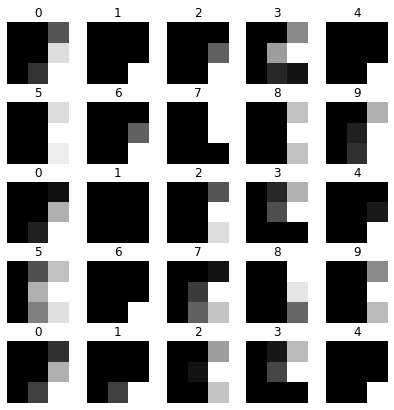

In [167]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=.25)

for i, ax in enumerate(grid):
    img = pixels.iloc[i].values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.set_title(digits.iloc[i])
    ax.axis('off')

How about if we take a look at 0 digits?

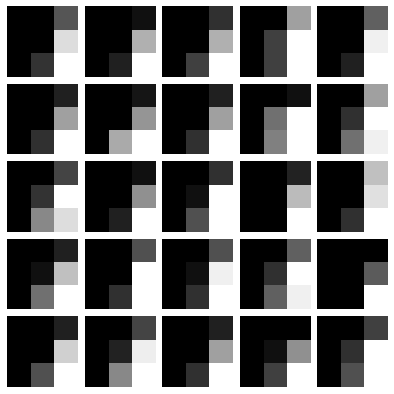

In [168]:
fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=.1)

zeros = pixels[digits == 0]

for i, ax in enumerate(grid):
    img = zeros.iloc[i].values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

We will define a Bayesian network where each node represents a pixel. Each edge will indicate that the intensity of a pixel is influenced by the intensities of its neighbors.

Let's first define a notion of "neighborhood". Let's say that a pixel's neighbors are the ones that are directly above and to the left of said pixel.

In [169]:
def neighbors(r, c):
    
    top = (r - 1, c)
    left = (r, c - 1)
    
    if r and c:
        return [top, left]
    if r:
        return [top]
    if c:
        return [left]
    return []

neighbors(0, 0)

[]

In [170]:
neighbors(0, 1)

[(0, 0)]

In [171]:
neighbors(1, 0)

[(0, 0)]

In [172]:
neighbors(1, 1)

[(0, 1), (1, 0)]

We can now use this function in order to define our Bayesian network.

In [173]:
import hedgehog

structure = [
    (f'{neighbor[0]}-{neighbor[1]}', f'{r}-{c}')
    for r in range(img_shape[0])
    for c in range(img_shape[1])
    for neighbor in neighbors(r, c)
]

bn = hedgehog.BayesNet(*structure)

We can represent this with Graphviz.

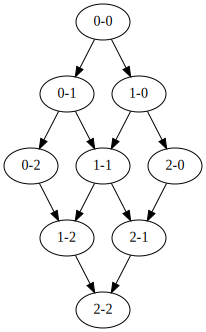

In [174]:
bn.graphviz()

We can also use [Daft](https://docs.daft-pgm.org/en/latest/) and arrange the nodes according to their associated pixel position.

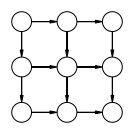

In [175]:
import daft

pgm = daft.PGM(node_unit=.7, grid_unit=1.6, directed=True)

for rc in bn.nodes:
    r, c = rc.split('-')
    pgm.add_node(node=rc, x=int(c), y=img_shape[0] - int(r))

for parent, children in bn.children.items():
    for child in children:
        pgm.add_edge(parent, child)

pgm.render();

To start off with, let's train such a Bayesian network on images that represent the 0 digit.

In [198]:
bn = hedgehog.BayesNet(*structure)
bn = bn.fit(pixels[digits == 0])

In [207]:
self = bn

def walk(node, visited):

    if node in visited:
        return

    yield node
    visited.add(node)

    for child in self.children.get(node, []):
        yield from walk(child, visited)

    for parent in self.parents.get(node, []):
        yield from walk(parent, visited)
        
order = list(walk('0-0', set()))
order

['0-0', '0-1', '0-2', '1-2', '2-2', '2-1', '1-1', '1-0', '2-0']

In [210]:
from hedgehog.bayes_net import pointwise_mul

init = {}
P = {}

for i, node in enumerate(order):

    p = self.P[node]

    if node in init:
        p = p[p.index.get_level_values(node) == init[node]]
        
    conditioning = sorted(list(set(order[:i]).intersection(self.markov_boundary(node))))

    if conditioning:
        p = pointwise_mul([p, pointwise_mul(self.P[c] for c in conditioning)])
        p = p.groupby([*conditioning, node]).sum()
        p = p.groupby(conditioning).apply(lambda g: g / g.sum())

    P[node] = p

In [211]:
while True:

    sample = init.copy()

    for node in order:
        p = P[node]
        if len(p.index.names) > 1:
            condition = tuple(sample[c] for c in p.index.names[:-1])
            p = p.cdt[condition]
        sample[node] = p.cdt.sample()

KeyError: (2, 0, 5, 4)

## START DEBUG

In [280]:
sample

{'0-0': 0, '0-1': 2, '0-2': 0, '1-2': 5, '2-2': 16, '2-1': 4}

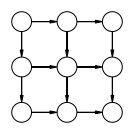

In [188]:
pgm.render();

In [279]:
import numpy as np

sampled = list(sample.items())

for i in range(len(sampled)):
    mask = np.ones(len(pixels), dtype=bool)
    
    for var, val in sampled[:i+1]:
        mask = mask & pixels[var].eq(val)
        
    print(sampled[i], mask.sum())

('0-0', 0) 1797
('0-1', 2) 67
('0-2', 0) 1
('1-2', 5) 1
('2-2', 16) 0
('2-1', 4) 0


In [284]:
mask = np.ones(len(pixels), dtype=bool)

for var, val in [sampled[1], sampled[2], sampled[3], sampled[5]]:
    mask = mask & pixels[var].eq(val)
    
mask.sum()

0

In [141]:
for i, node in enumerate(order):
    print(node, sorted(list(set(order[:i]).intersection(self.markov_boundary(node)))))

0-0 []
0-1 ['0-0']
0-2 ['0-1']
1-2 ['0-2']
2-2 ['1-2']
2-1 ['1-2', '2-2']
1-1 ['0-1', '0-2', '1-2', '2-1']
1-0 ['0-0', '0-1', '1-1']
2-0 ['1-0', '1-1', '2-1']


## END DEBUG

KeyError: (15, 1, 16)

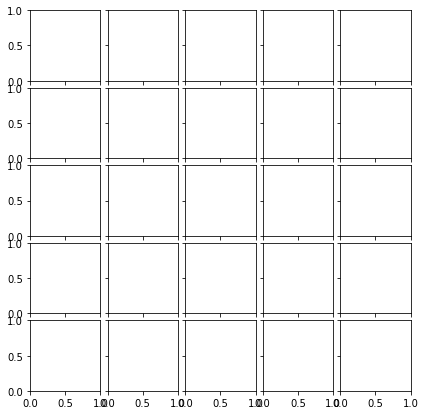

In [76]:
import pandas as pd

fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=.1)

for ax in grid:
    sample = next(sampler)
    img = pd.Series(sample).values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

We can attempt to empower the Bayesian network by making each pixel also depend on its top-left neighbor, in addition to the top one and the left one.

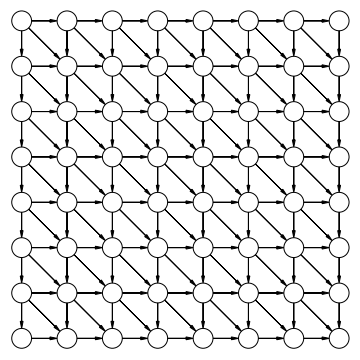

In [63]:
def neighbors(r, c):
    
    top_left = (r - 1, c - 1)
    left = (r, c - 1)
    top = (r - 1, c)
    
    if r and c:
        return [top, left, top_left]
    if r:
        return [top]
    if c:
        return [left]
    return []

bn = hedgehog.BayesNet(*[
    (f'{neighbor[0]}-{neighbor[1]}', f'{r}-{c}')
    for r in range(img_shape[0])
    for c in range(img_shape[1])
    for neighbor in neighbors(r, c)
])

pgm = daft.PGM(node_unit=.7, grid_unit=1.6, directed=True)

for rc in bn.nodes:
    r, c = rc.split('-')
    pgm.add_node(node=rc, x=int(c), y=img_shape[0] - int(r))

for parent, children in bn.children.items():
    for child in children:
        pgm.add_edge(parent, child)

pgm.render();

In [73]:
bn = hedgehog.BayesNet(*structure)
bn = bn.fit(pixels[digits == 0])
sampler = bn._flood_fill_sampling()

StopIteration: 

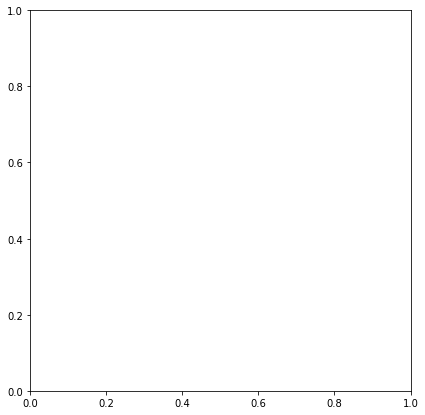

In [68]:
fig = plt.figure(figsize=(7, 7))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 1), axes_pad=.1)

for ax in grid:
    sample = next(sampler)
    img = pd.Series(sample).values.reshape(img_shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')